Perform an area-wide correlation analysis of vehicle emissions.
Determine spatial variation, and variation based on other factors, such as land use of surrounding areas, population, network classification (road type), weather, etc.
Correlate the provided emissions data with other provided datasets.

Population = building population?
weather = weather underground 

Expected increase in air temperature per 100 W/m2 traffic heat exhaust is approximately 0.8 C based on a modeled average in the experiments of Oke et al. (2017).

### Global imports

In [127]:
import pandas as pd
import xarray as xr
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import glob
from sklearn.cluster import KMeans
from mpl_toolkits.mplot3d import Axes3D

In [383]:
building_map=gpd.read_file("data/building_data/Building_Footprints/buildings_clipped.geojson")
building_map = building_map.to_crs(epsg=4326)

In [546]:
links=gpd.read_file("data/road_network/RoadNetwork.geojson")
links = links.rename(columns={'LINKID': 'linkID'})
links=links.to_crs(epsg=26916)

In [298]:
emissions=pd.read_csv('data/emissions_data/Emissions/2017-01-09_07_energy.csv')

In [398]:
sim_snap_geojson = gpd.read_file("data/vehicle_data/Simulation_Snapshot/snapshot_small.geojson")
def start(sim_snap_df:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_start_gpd = sim_snap_df.head(1)
    return sim_start_gpd

def end(sim_snap_df:str):
    sim_snap_df = sim_snap_geojson.groupby('VEHICLE')
    sim_end_gpd = sim_snap_df.tail(1)
    return sim_end_gpd

In [412]:
sim_end=end(sim_snap_geojson)
sim_end=sim_end.to_crs(epsg=4326)

### Readme suggests converting simulation to W/m2
To Get W/m2 for each link:
Divide the MMBtu (emquant) values for each link at each hour by 3600 to get MMBtu/s, then divide that value by the square area of the link in feet (LINKAREA_F).  This gives MMBtu/s/ft^2
This value is then multiplied by: 11356.538527 to get to Wm-2. 

Linkarea does not exist ?

I will multiply by 15 meters (assumed width of a link). Can revisit.

In [5]:
links['linkID']=links['linkID'].astype(int)
links['linkarea']=(links.geometry.length)*15
links['linkarea_f']=links['linkarea']*10.7639

### Concatenate days of emissions data

Sorted filenames and added datetimes.

In [9]:
path = r'data/emissions_data/Emissions/' # use your path
jan2017 = glob.glob(path + "/2017-01-09*.csv")
li = []
jan2017.sort()
for filename in jan2017:
    df = pd.read_csv(filename, index_col=None, header=0)
    hour=str(df.loc[0,'hour'])
    df['date'] = filename[30:40]+'-'+hour+':00'
    df['date']=pd.to_datetime(df['date'])
    li.append(df)

jan_2017 = pd.concat(li, axis=0, ignore_index=True)

In [33]:
path = r'data/emissions_data/Emissions/' # use your path
july2017 = glob.glob(path + "/2017-07*.csv")
li = []
july2017.sort()
for filename in july2017:
    df = pd.read_csv(filename, index_col=None, header=0)
    hour=str(df.loc[0,'hour'])
    df['date'] = filename[30:40]+'-'+hour+':00'
    df['date']=pd.to_datetime(df['date'])
    li.append(df)

july_2017 = pd.concat(li, axis=0, ignore_index=True)

merge with links for geometry and calculate the W/m

In [561]:
merged_linkarea=pd.merge(left=links,right=july_2017,left_on='linkID',right_on='linkID')
merged_linkarea
merged_linkarea['mmbtu_s']=merged_linkarea['emquant']/3600
merged_linkarea['mmbtusft']=merged_linkarea['mmbtu_s']/merged_linkarea['linkarea_f']
merged_linkarea['Wm2']= merged_linkarea['mmbtusft']*11356.538527

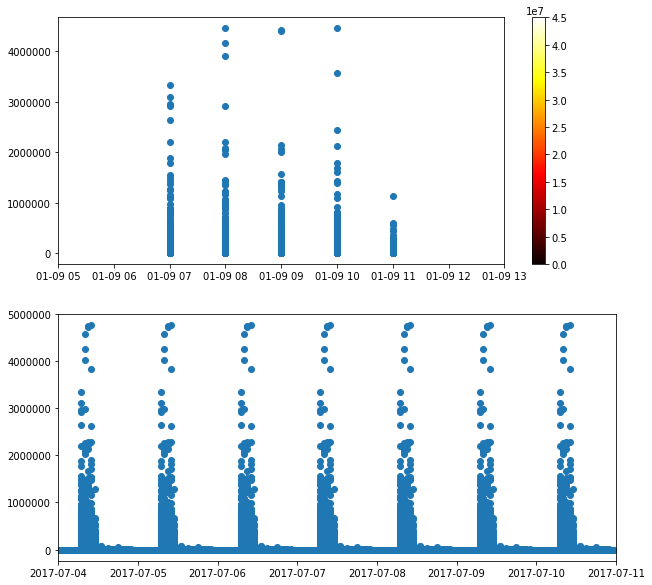

In [36]:
f, (ax1, ax2) = plt.subplots(2,figsize = (10,10))
ax1.scatter(jan_2017['date'], jan_2017['emquant']) 
ax1.set_xlim(pd.to_datetime('2017-01-09 05:00:00'),pd.to_datetime('2017-01-09 13:00:00'))
ax2.scatter(july_2017['date'], july_2017['emquant']) # is this right?
ax2.set_xlim(pd.to_datetime('2017-07-04 00:00:00'),pd.to_datetime('2017-07-11 00:00:00'))
sm = plt.cm.ScalarMappable(cmap='hot', norm=plt.Normalize(vmin=0, vmax=45000000))
fig.colorbar(sm, ax=ax1)
plt.show()

## Population

merge Community Area Boundaries shapefile + 2013 -2017 document.

#### Question - do we want to go onto census tract level?

In [645]:
population=pd.read_csv('data/socioeconomic_data/Population/2013-2017.csv')
community_bound=gpd.read_file("data/socioeconomic_data/Community Area Snapshots/Boundaries_Community_Areas_current.geojson")
reproj=gpd.read_file("reproj.geojson")

Rename columns and merge

In [586]:
population = population.rename(columns={'GEOG': 'community'})
population['community']=population['community'].apply(lambda x: x.upper())
pop_georef=population.merge(community_bound, on='community')

In [670]:
pop_gpd=gpd.GeoDataFrame(reproj, geometry='geometry')
#pop_gpd.to_file("pop_georef.geojson", driver='GeoJSON')
pop_gpd

,community,2000_POP,2010_POP,TOT_POP,UND19,A20_34,A35_49,A50_64,A65_74,A75_84,...,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,area_2,perimeter_2,geometry
0,ALBANY PARK,57655,51542,51992,13299,14031,11658,8134,2603,1573,...,53542230.8191,0,14,14,0,0,39339.0164387,4.970649e+06,11986.210723,"MULTIPOLYGON (((441668.975 4647079.380, 441669..."
1,ARCHER HEIGHTS,12644,13393,13142,4017,2827,2925,1818,970,323,...,55922505.7212,0,57,57,0,0,31880.0210295,5.191636e+06,9713.537531,"MULTIPOLYGON (((440676.594 4630708.634, 440676..."
2,ARMOUR SQUARE,12032,13391,13455,2634,2816,2376,2522,1540,1097,...,27766196.0954,0,34,34,0,0,31948.5988398,2.577602e+06,9734.228917,"MULTIPOLYGON (((447767.863 4632820.107, 447743..."
3,ASHBURN,39584,41081,43792,12999,8377,9200,8567,3031,999,...,135460337.208,0,70,70,0,0,54818.1546317,1.257553e+07,16702.499879,"MULTIPOLYGON (((440764.644 4623079.547, 440767..."
4,AUBURN GRESHAM,55928,48743,46278,11696,9176,7871,9857,3810,2966,...,105065353.602,0,71,71,0,0,46757.7217161,9.753564e+06,14246.399521,"MULTIPOLYGON (((446803.022 4622899.783, 446802..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,WEST LAWN,29235,33355,33108,11067,7535,6990,4642,1748,805,...,82315301.6831,0,65,65,0,0,41934.4901309,7.641847e+06,12777.038875,"MULTIPOLYGON (((440764.644 4623079.547, 440745..."
72,WEST PULLMAN,36649,29651,27742,7812,5719,4594,5351,2719,1178,...,99365198.0822,0,53,53,0,0,50023.8430008,9.224314e+06,15241.475778,"MULTIPOLYGON (((448522.917 4612112.998, 448522..."
73,WEST RIDGE,73199,71942,76215,20756,17065,15001,13648,5461,2914,...,98429094.8621,0,2,2,0,0,43020.6894583,9.137658e+06,13107.897328,"MULTIPOLYGON (((443315.818 4652166.308, 443316..."
74,WEST TOWN,87435,82236,84502,13570,37651,19528,8662,3234,1429,...,127562904.597,0,24,24,0,0,55203.7186956,1.184219e+07,16819.848609,"MULTIPOLYGON (((445524.300 4640079.398, 445525..."


In [683]:
#str(merged_linkarea.geometry[1])
#.within(pop_gpd.geometry)#.sort_values(ascending=True)
str(pop_gpd.geometry[1])

'MULTIPOLYGON (((440676.5943317635 4630708.633765371, 440676.8322460145 4630663.329370959, 440676.8319357067 4630663.301523792, 440676.8309296083 4630663.213138309, 440675.4031875127 4630538.533254336, 440677.4966411304 4630531.073091186, 440677.5322307541 4630521.09272244, 440677.5704896405 4630513.740606981, 440677.6025818097 4630508.445459198, 440677.6378601148 4630508.295656746, 440678.7380013922 4630503.629708917, 440680.4052662505 4630411.51832315, 440680.4179946515 4630410.816767594, 440682.218009042 4630311.374747398, 440682.3010579742 4630306.784737851, 440676.6216538345 4630285.70579852, 440676.4412170628 4630281.442430792, 440676.2613713391 4630277.217144677, 440676.195179506 4630272.95200395, 440676.1732365993 4630266.629243622, 440676.7226480243 4630208.760844684, 440678.5136746456 4630073.815489311, 440679.1682912692 4630005.546644428, 440679.934980567 4629924.858465212, 440681.8551073632 4629808.042324498, 440682.1094454298 4629777.794325854, 440682.4460630909 4629762.66

In [662]:
pd.merge(left=merged_linkarea,right=pop_gpd

,linkID,FROM,TO,FCC,SPEED,MILES,LANES,DIRECT,geometry,linkarea,...,hour,pollutantID,emrate,emquant,date,idx,quant_norm,mmbtu_s,mmbtusft,Wm2
0,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,...,0,91,0.0,0.0,2017-07-04 00:00:00,0,0.0,0.0,0.0,0.0
1,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,...,1,91,0.0,0.0,2017-07-04 01:00:00,1,0.0,0.0,0.0,0.0
2,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,...,2,91,0.0,0.0,2017-07-04 02:00:00,2,0.0,0.0,0.0,0.0
3,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,...,3,91,0.0,0.0,2017-07-04 03:00:00,3,0.0,0.0,0.0,0.0
4,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,...,4,91,0.0,0.0,2017-07-04 04:00:00,4,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195043,2604,543,-260,A00,None,None,None,0,"LINESTRING (446456.940 4636163.858, 446445.661...",171.525705,...,19,91,0.0,0.0,2017-07-10 19:00:00,163,0.0,0.0,0.0,0.0
195044,2604,543,-260,A00,None,None,None,0,"LINESTRING (446456.940 4636163.858, 446445.661...",171.525705,...,20,91,0.0,0.0,2017-07-10 20:00:00,164,0.0,0.0,0.0,0.0
195045,2604,543,-260,A00,None,None,None,0,"LINESTRING (446456.940 4636163.858, 446445.661...",171.525705,...,21,91,0.0,0.0,2017-07-10 21:00:00,165,0.0,0.0,0.0,0.0
195046,2604,543,-260,A00,None,None,None,0,"LINESTRING (446456.940 4636163.858, 446445.661...",171.525705,...,22,91,0.0,0.0,2017-07-10 22:00:00,166,0.0,0.0,0.0,0.0


In [661]:
merged_jan#.geometry.within(reproj.geometry).sort_values(ascending=False)

,linkID,FROM,TO,FCC,SPEED,MILES,LANES,DIRECT,geometry,linkarea,linkarea_f,hour,pollutantID,emrate,emquant,date,quant_norm
0,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,10996.746848,7,91,8.210320e+05,30751.423168,2017-01-09 07:00:00,0.006906
1,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,10996.746848,8,91,5.268288e+06,197321.631992,2017-01-09 08:00:00,0.044316
2,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,10996.746848,9,91,7.859347e+05,29436.868437,2017-01-09 09:00:00,0.006611
3,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,10996.746848,10,91,2.536306e+05,9499.631362,2017-01-09 10:00:00,0.002133
4,2,2,3,A50,None,None,None,0,"LINESTRING (448119.839 4636306.675, 448051.789...",1021.632201,10996.746848,11,91,3.982374e+04,1491.582044,2017-01-09 11:00:00,0.000335
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5800,2604,543,-260,A00,None,None,None,0,"LINESTRING (446456.940 4636163.858, 446445.661...",171.525705,1846.285540,7,91,9.966412e+04,464.463107,2017-01-09 07:00:00,0.000104
5801,2604,543,-260,A00,None,None,None,0,"LINESTRING (446456.940 4636163.858, 446445.661...",171.525705,1846.285540,8,91,8.314120e+04,387.461608,2017-01-09 08:00:00,0.000087
5802,2604,543,-260,A00,None,None,None,0,"LINESTRING (446456.940 4636163.858, 446445.661...",171.525705,1846.285540,9,91,3.100630e+04,144.498155,2017-01-09 09:00:00,0.000032
5803,2604,543,-260,A00,None,None,None,0,"LINESTRING (446456.940 4636163.858, 446445.661...",171.525705,1846.285540,10,91,2.870931e+04,133.793529,2017-01-09 10:00:00,0.000030


In [ ]:
fig,ax=plt.subplots(figsize=(10,10))
merged_jan.plot(ax=ax, column='',cmap='Purples',vmin=0, vmax=0.5)

## Isolate links

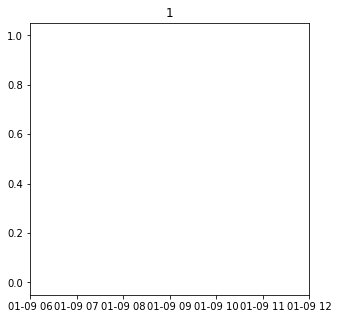

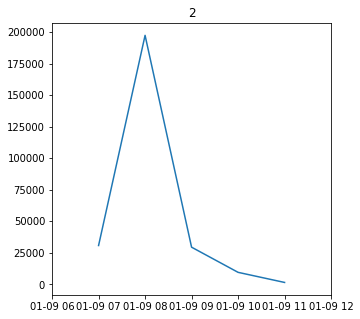

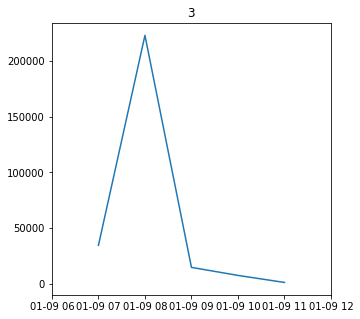

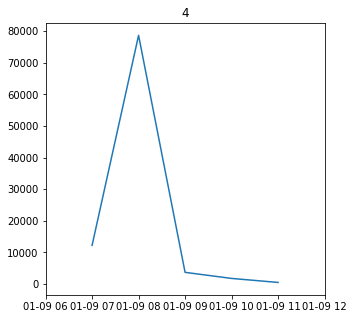

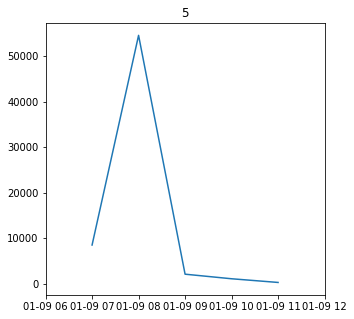

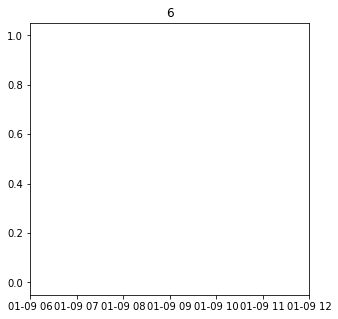

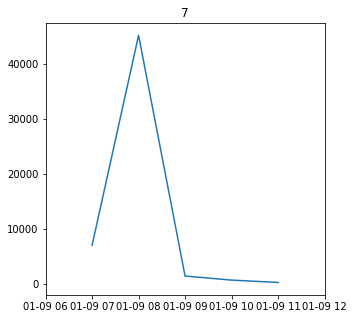

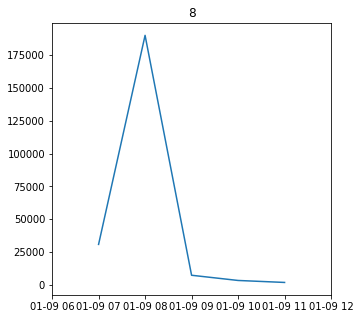

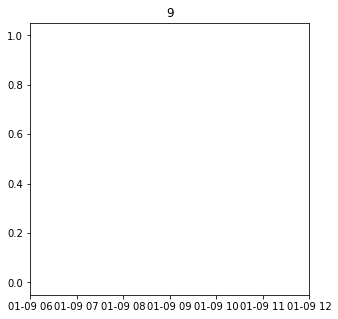

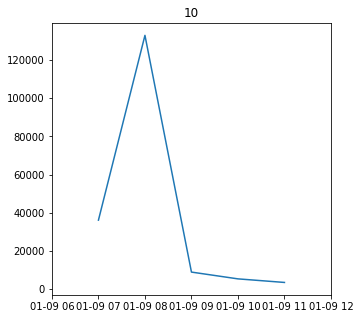

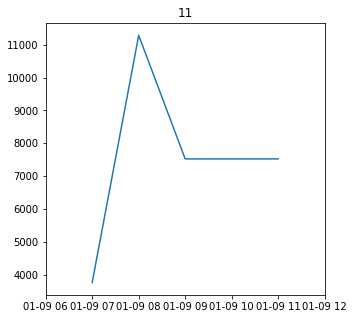

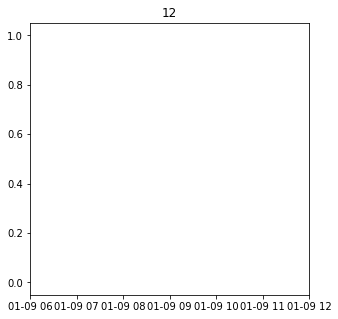

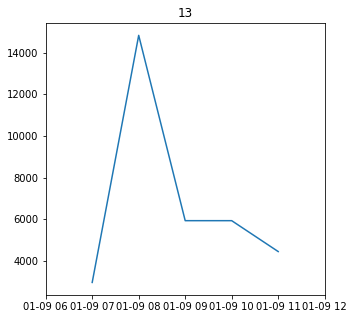

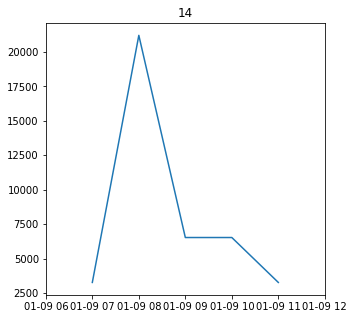

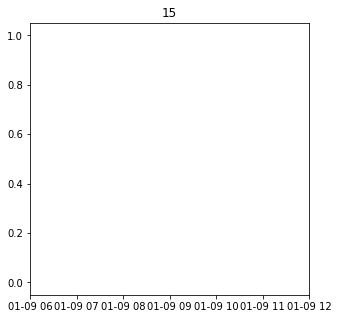

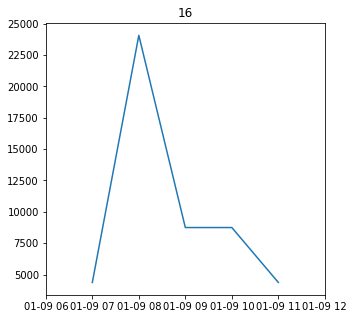

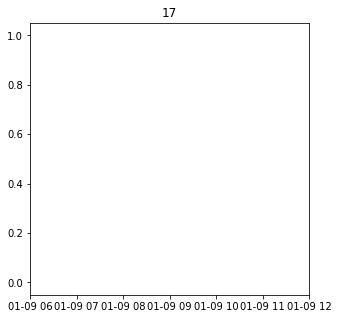

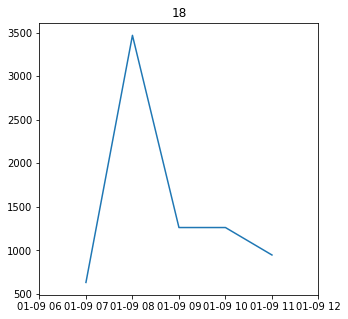

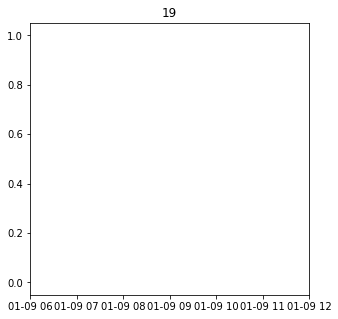

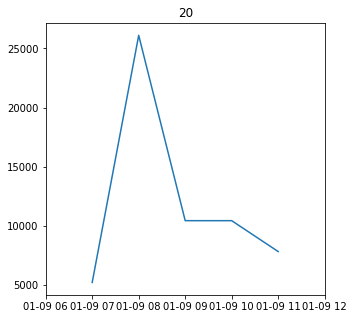

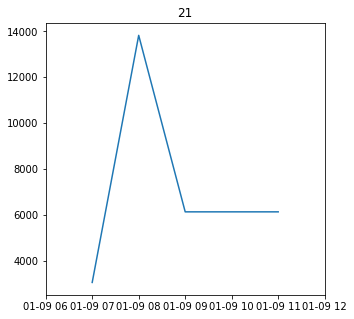

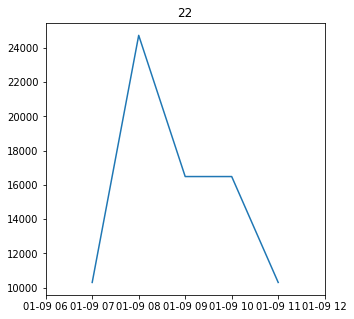

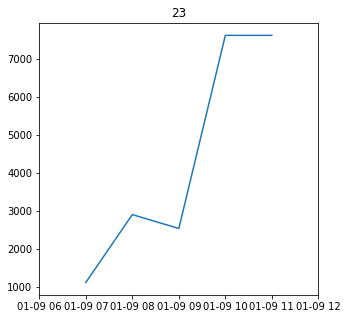

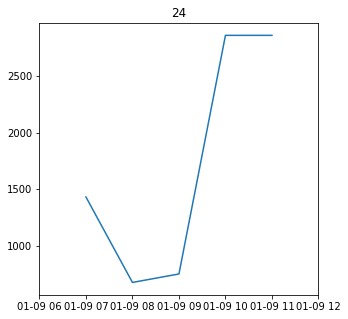

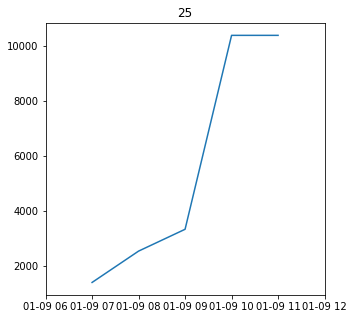

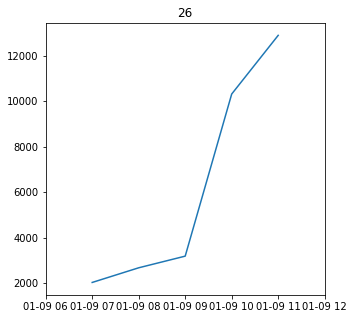

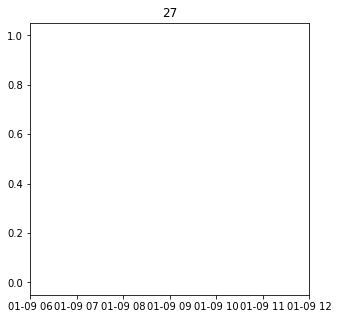

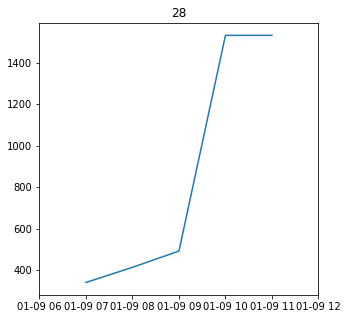

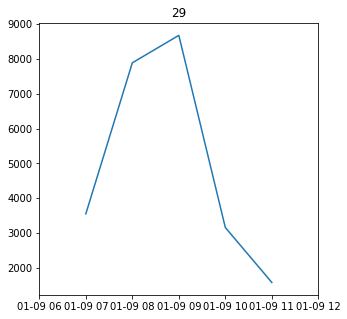

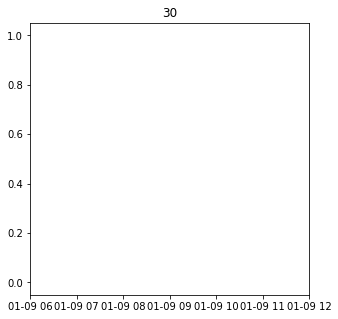

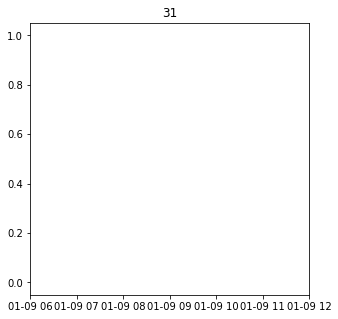

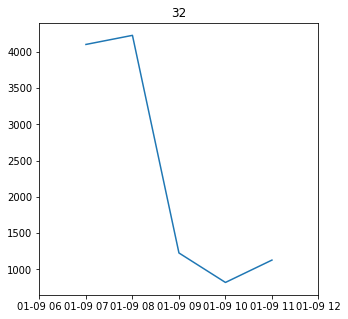

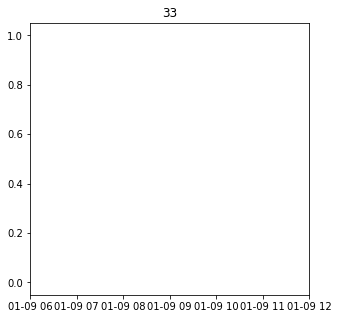

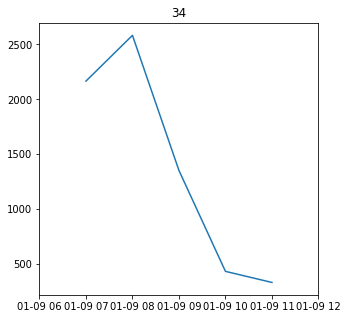

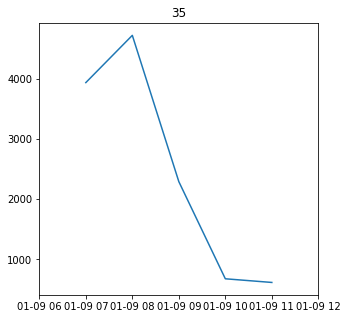

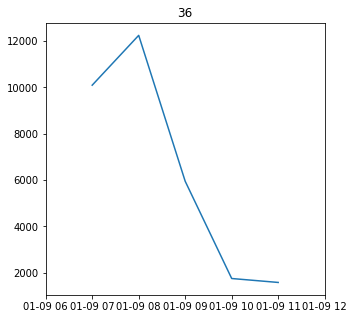

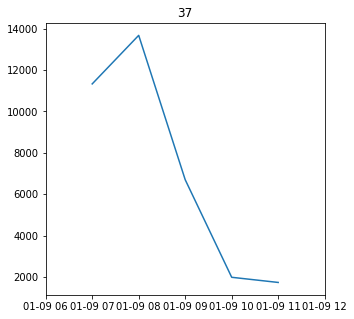

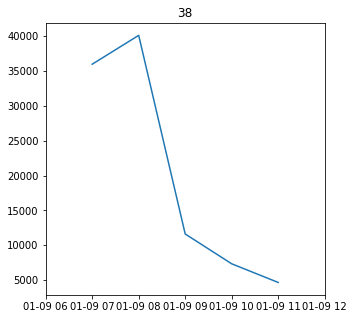

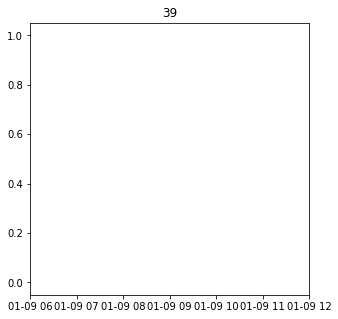

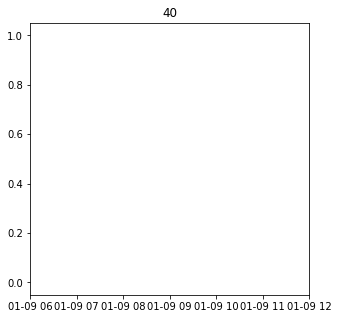

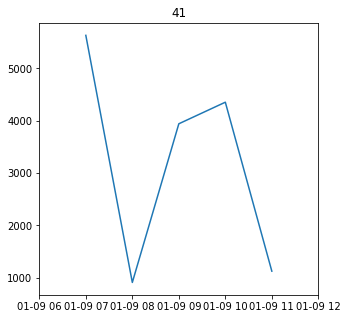

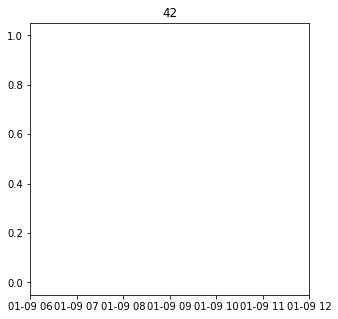

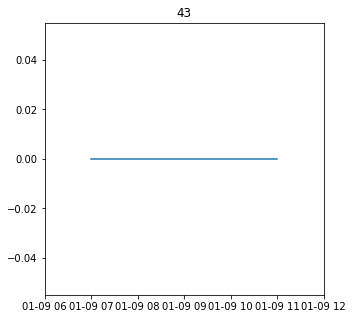

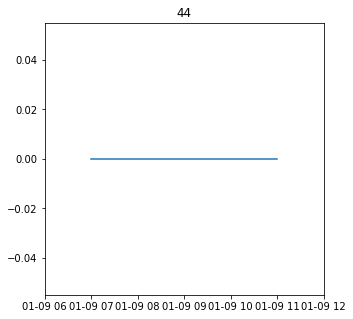

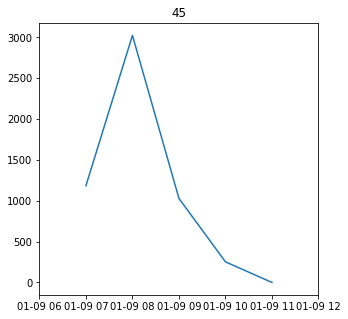

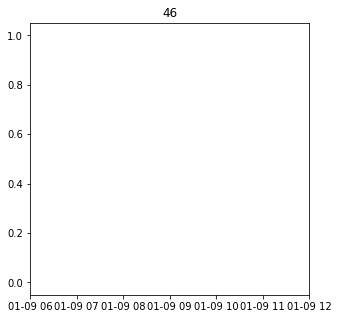

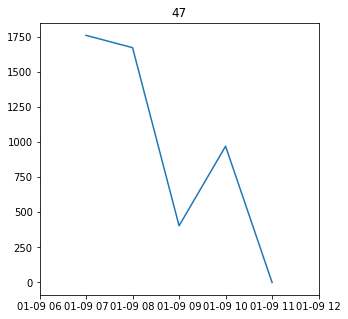

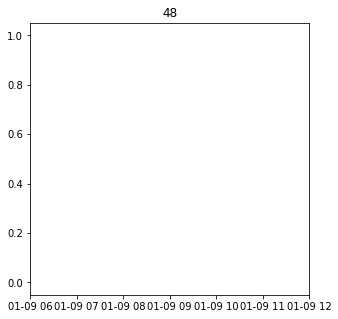

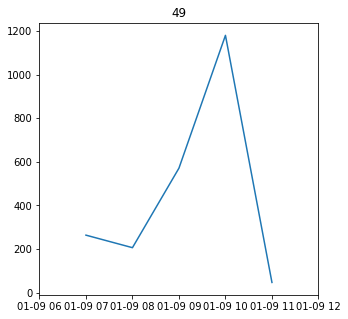

In [301]:
for i in np.arange(1,50,1):
#for i in np.arange(1,len(jan_2017),1):
    fig,ax=plt.subplots(figsize=(5,5))
    ax.plot(jan_2017.loc[jan_2017['linkID']==i,['date']],jan_2017.loc[jan_2017['linkID']==i,['emquant']])
    ax.set_xlim(pd.to_datetime('2017-01-09 06:00'),pd.to_datetime('2017-01-09 12:00'))
    ax.set_title(i)
    plt.show()

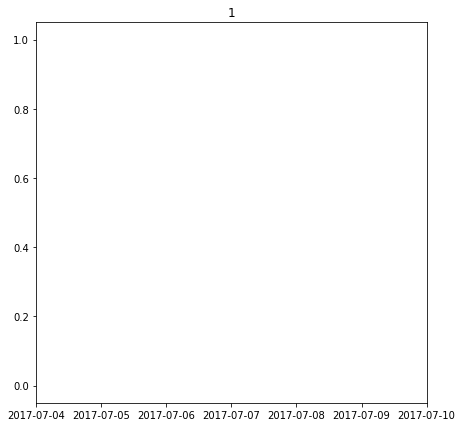

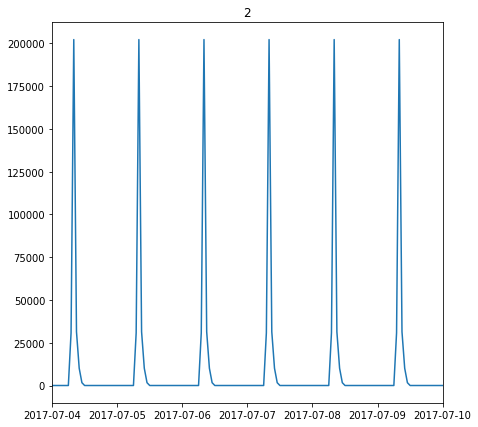

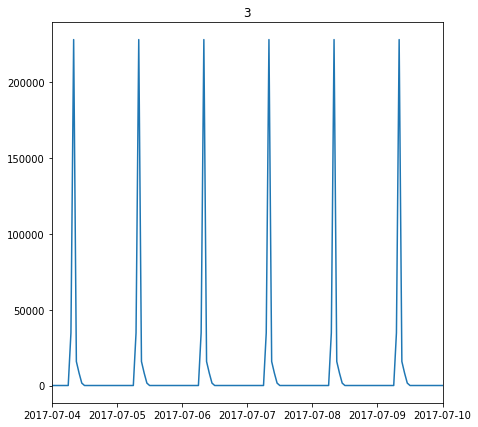

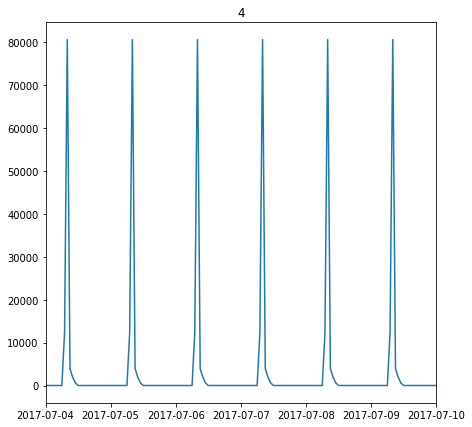

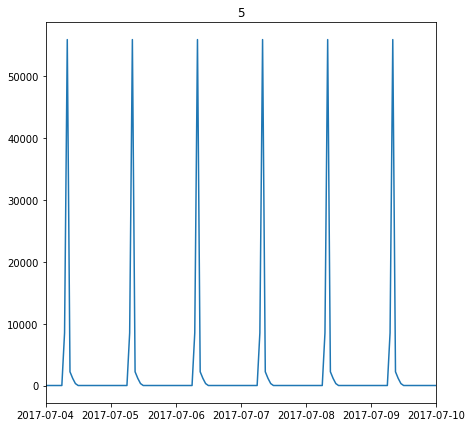

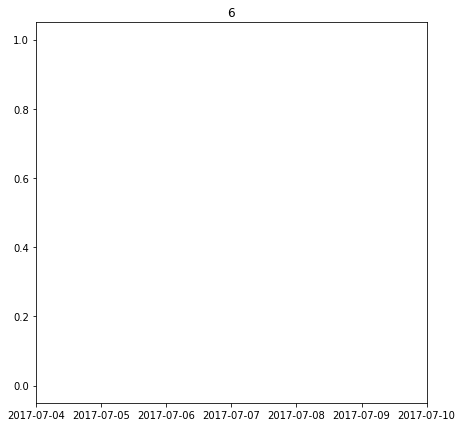

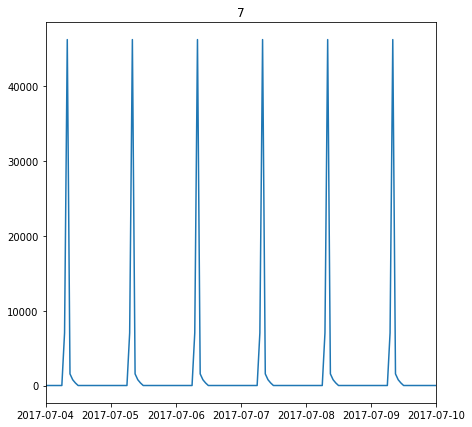

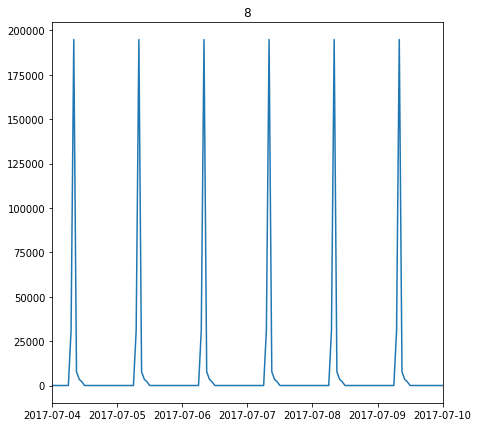

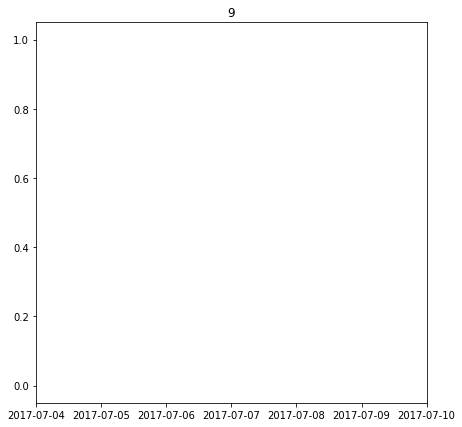

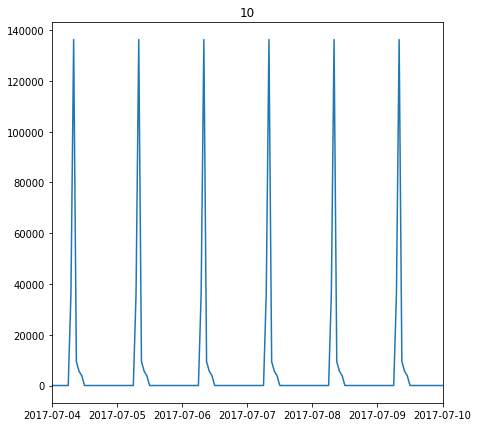

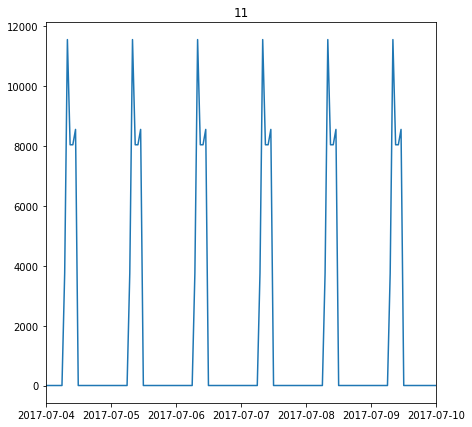

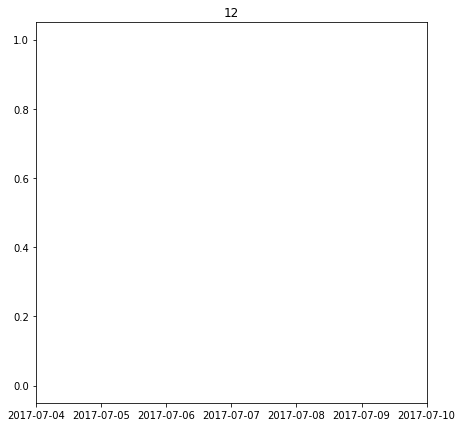

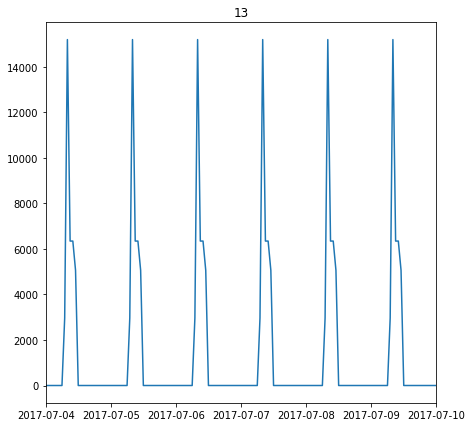

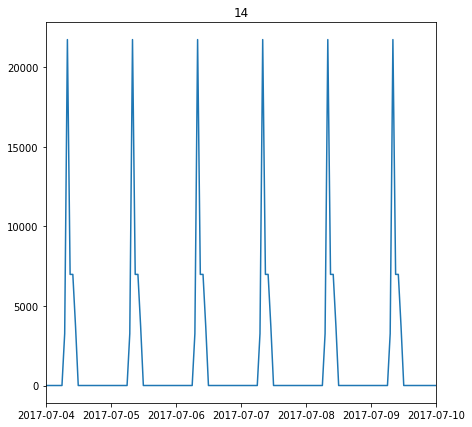

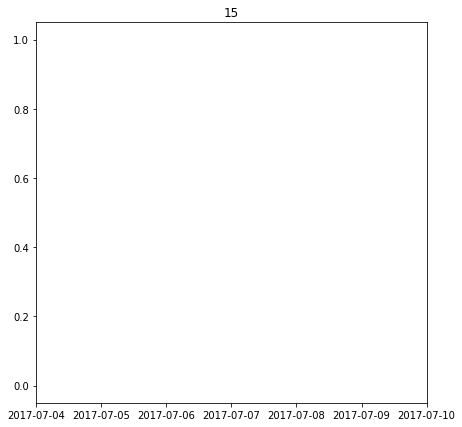

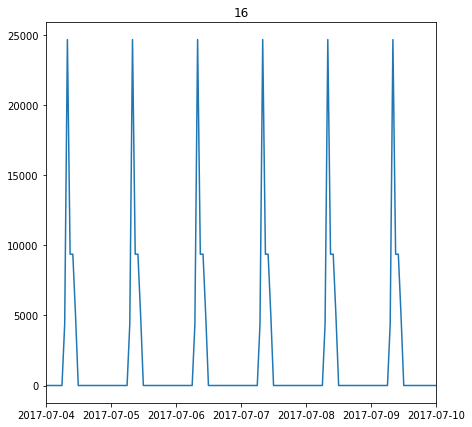

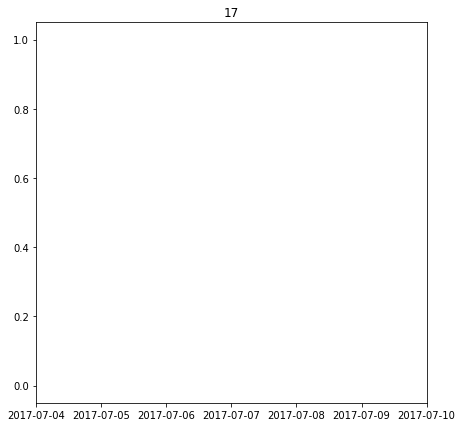

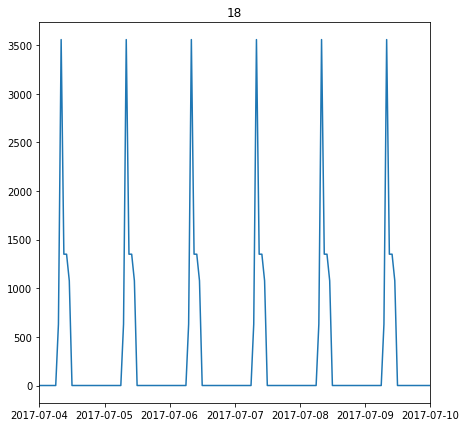

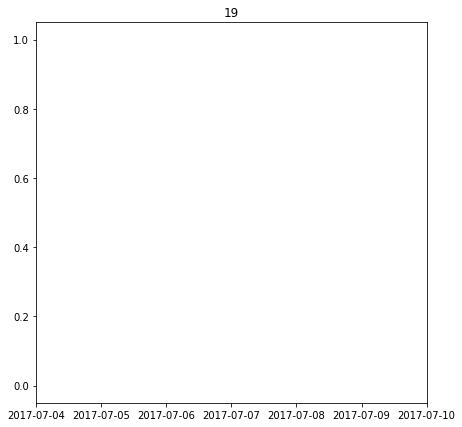

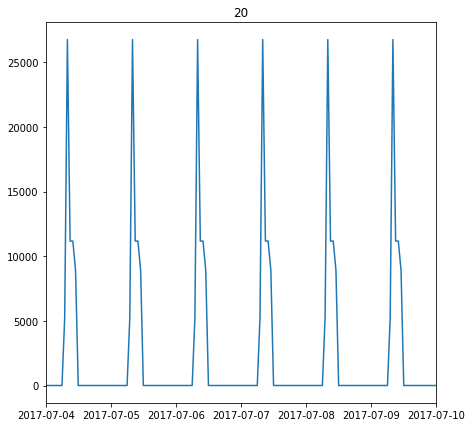

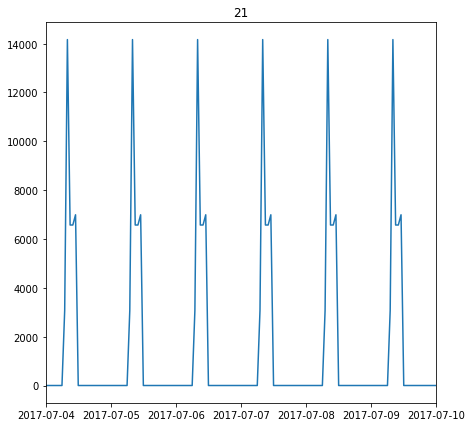

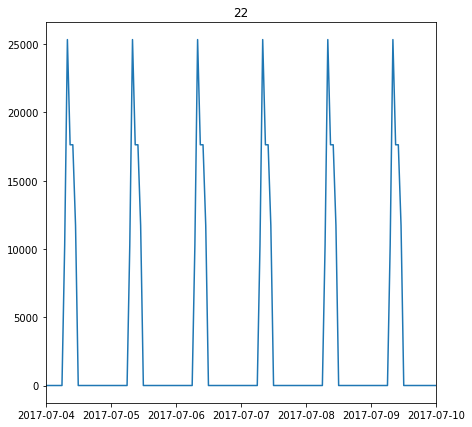

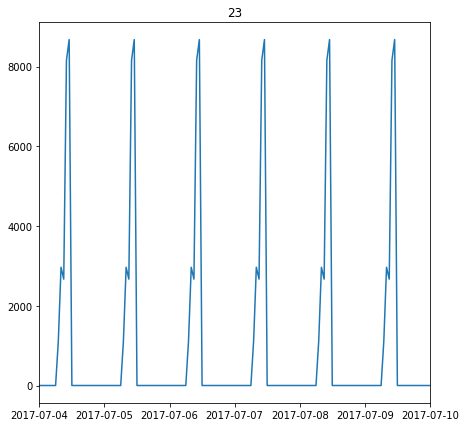

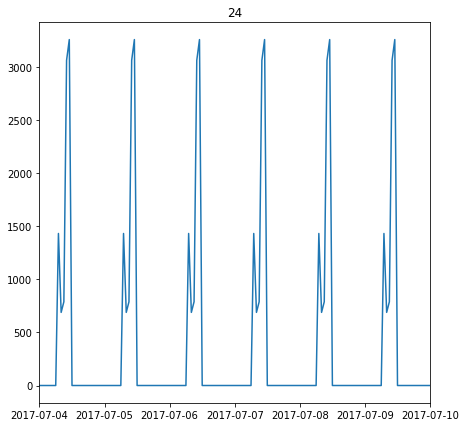

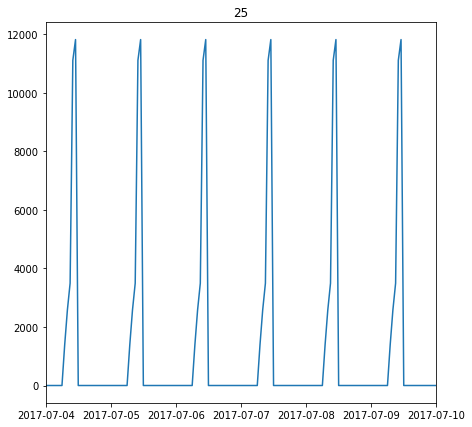

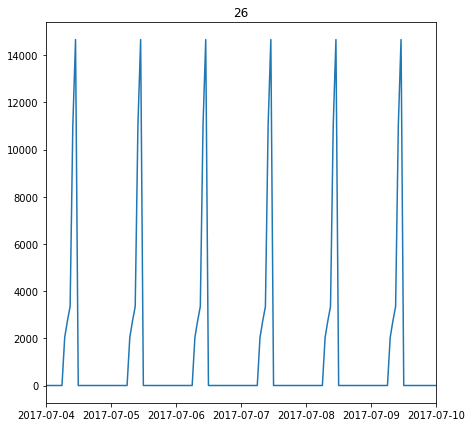

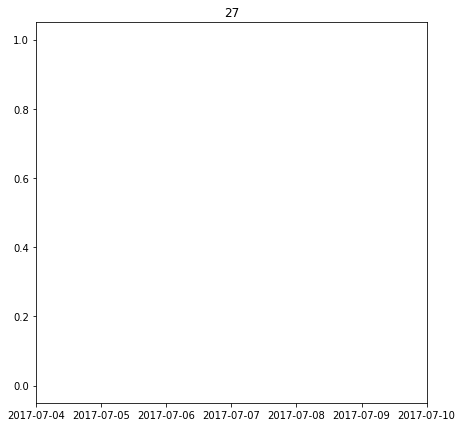

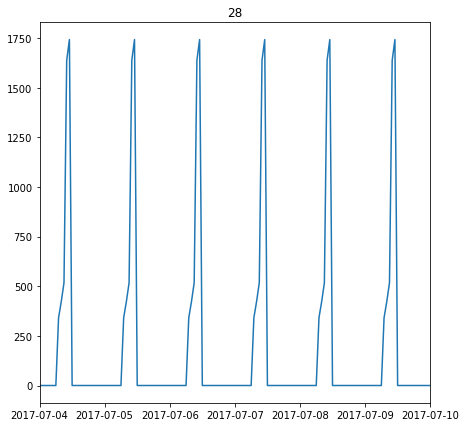

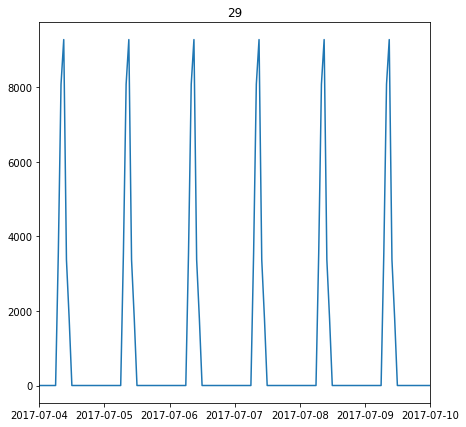

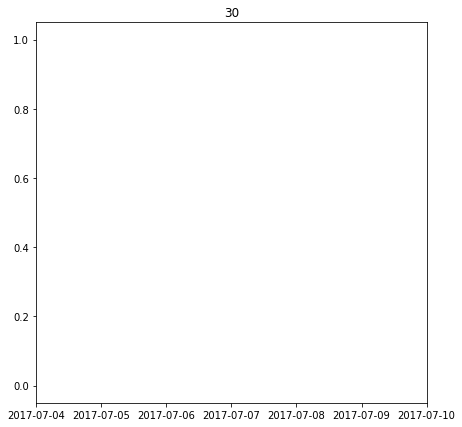

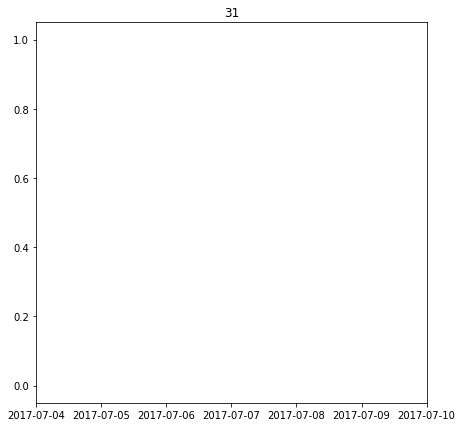

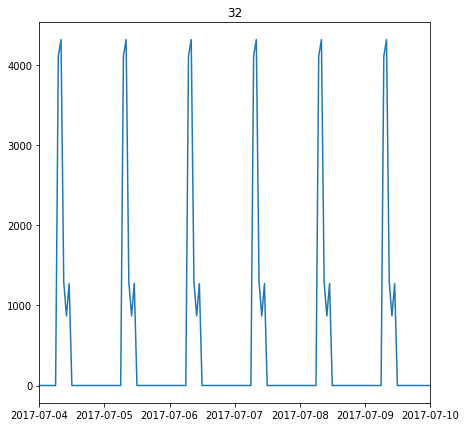

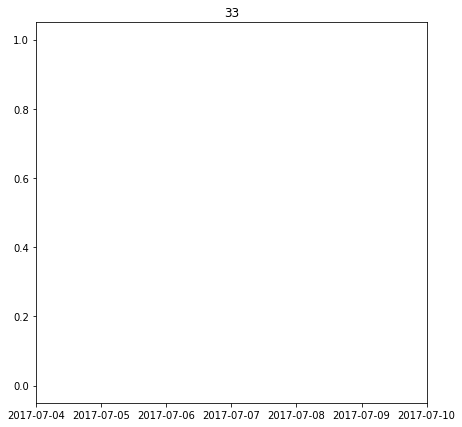

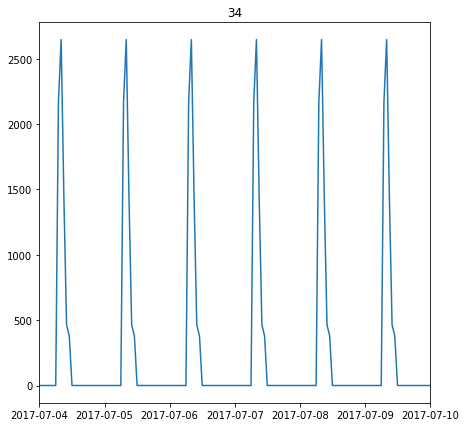

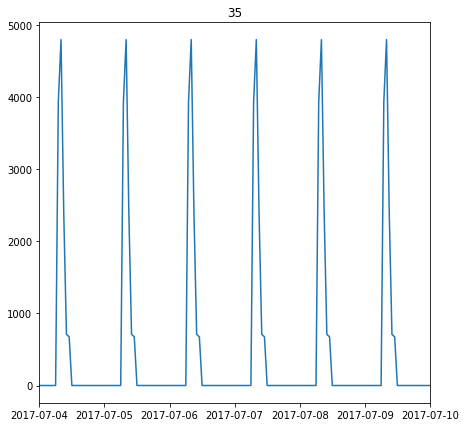

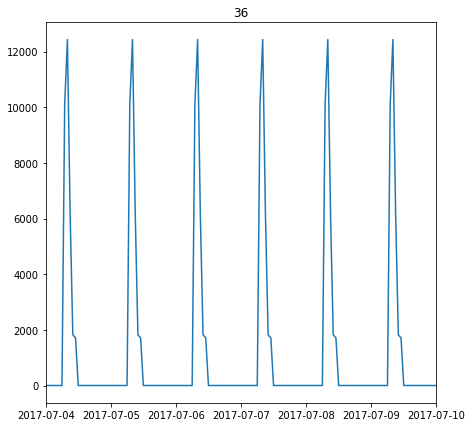

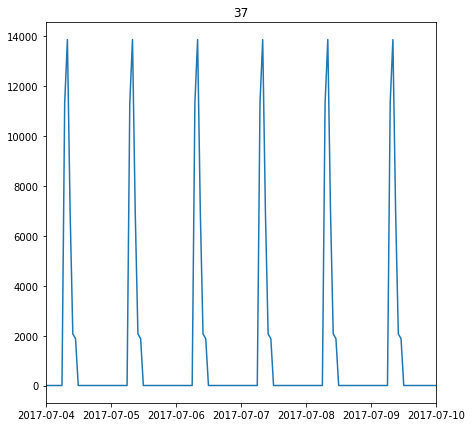

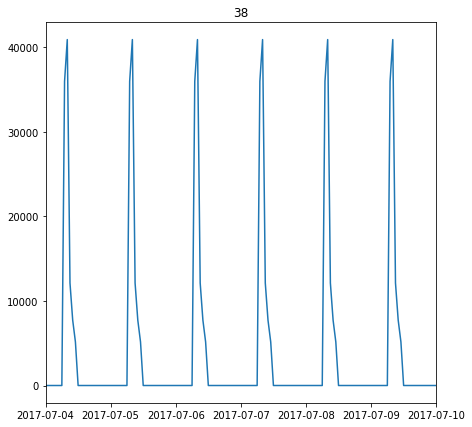

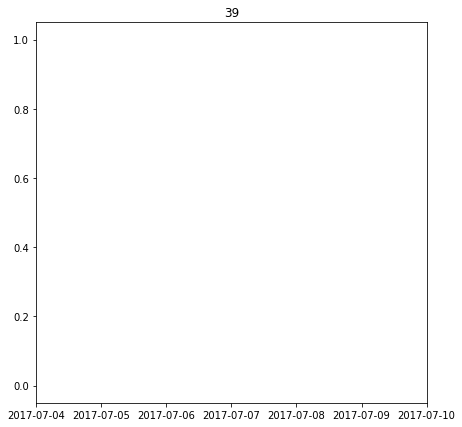

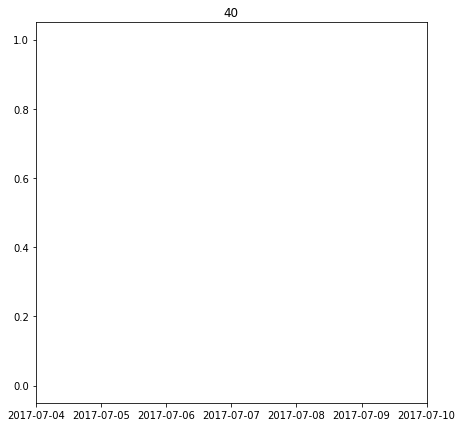

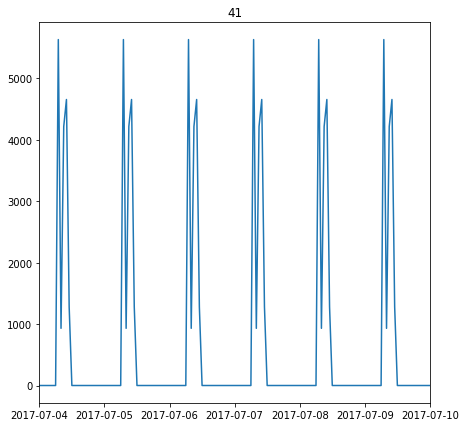

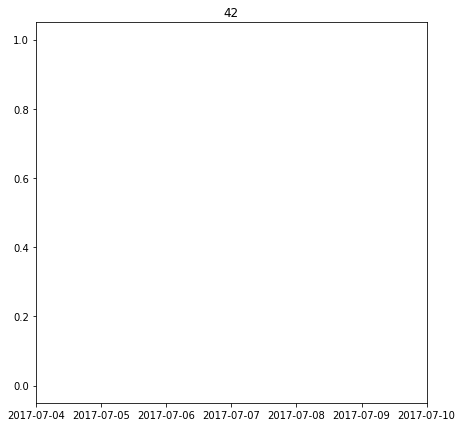

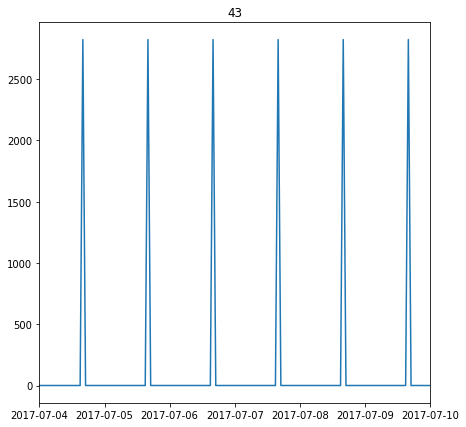

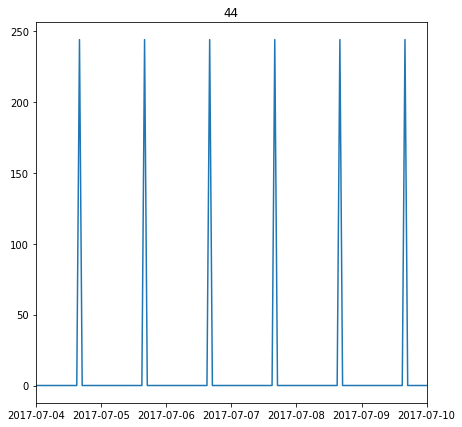

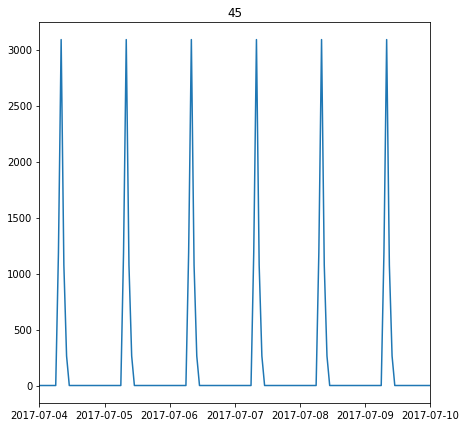

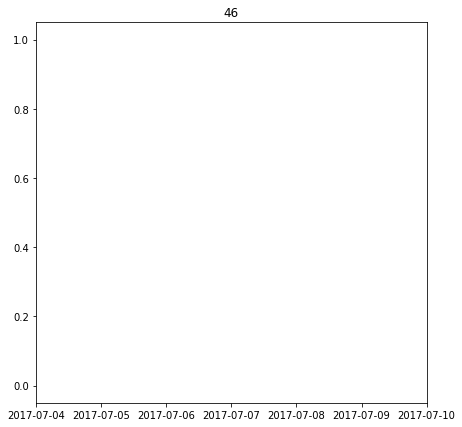

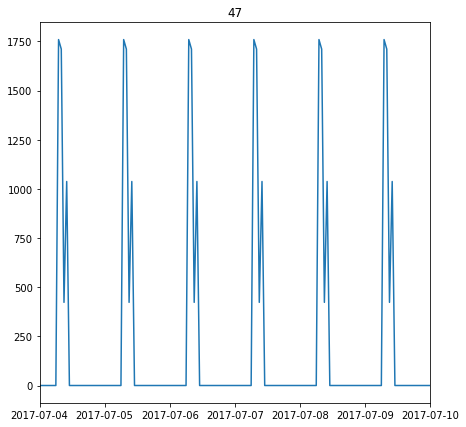

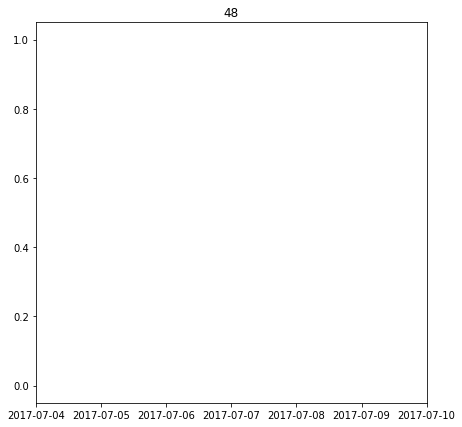

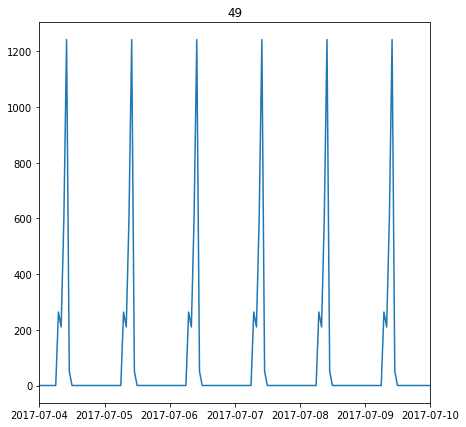

In [124]:
for i in np.arange(1,50,1):
#for i in np.arange(1,len(july_2017),1):
    fig,ax=plt.subplots(figsize=(7,7))
    ax.plot(july_2017.loc[july_2017['linkID']==i,['date']],july_2017.loc[july_2017['linkID']==i,['emquant']])
    ax.set_xlim(pd.to_datetime('2017-07-04'),pd.to_datetime('2017-07-10'))
    ax.set_title(i)
    plt.show()

### Let's cluster links with most similar emissions per simulation time step 

In [132]:
july_2017['idx'] = july_2017.groupby(['date']).ngroup()
X= july_2017[['linkID','emquant','idx']]
kmeans = KMeans(n_clusters=5, random_state=0)

Text(0.5, 0, 'emissions')

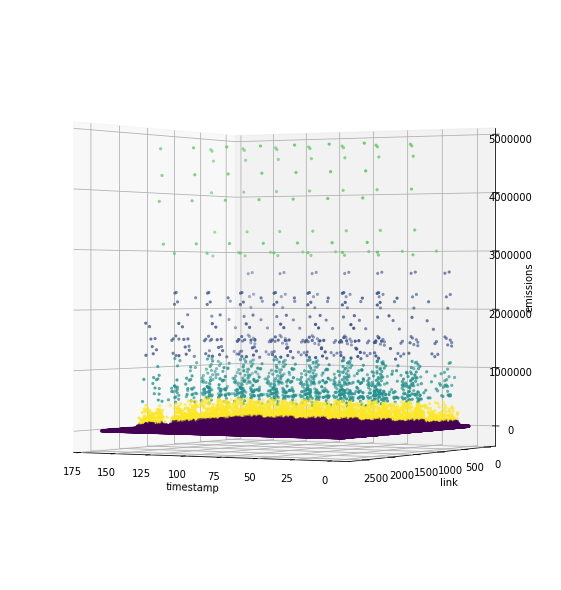

In [302]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=0, azim=120)
kmeans.fit(X)
labels = kmeans.labels_
ax.scatter(X['idx'], X['linkID'], X['emquant'], c=labels.astype(np.float),s=5)
ax.set_xlabel('timestamp')
ax.set_ylabel('link')
ax.set_zlabel('emissions')

In [172]:
labels=pd.DataFrame(labels)
result = pd.concat([july_2017, labels], axis=1)
result=result.rename(columns={0:'cluster_num'})

In [305]:
links['linkID']=links['linkID'].astype(int)
avg_result=result.groupby(['linkID']).mean()
snap1_result=result.groupby(['linkID']).head(8)
max_result=result.groupby(['linkID']).max()

In [306]:
merged_cluster=pd.merge(left=links,right=avg_result, left_on='linkID', right_on='linkID')
merged_snap1=pd.merge(left=links,right=snap1_result, left_on='linkID', right_on='linkID')
merged_max=pd.merge(left=links,right=max_result, left_on='linkID', right_on='linkID')

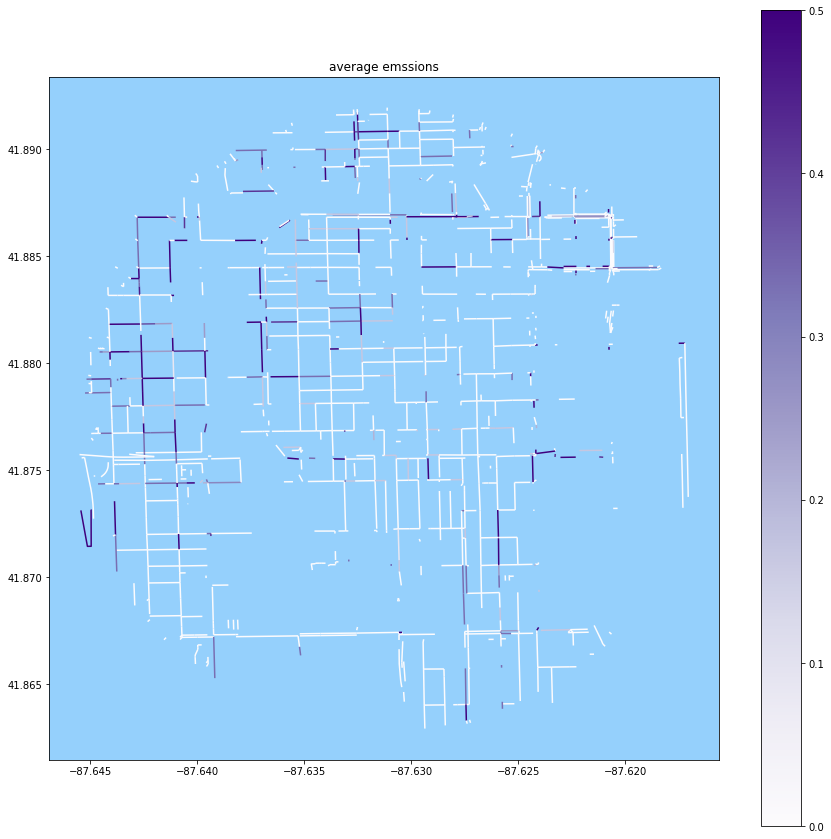

In [310]:
fig,ax = plt.subplots(figsize = (15,15))
merged_cluster.plot(ax=ax, column='cluster_num',cmap='Purples',vmin=0, vmax=0.5)
ax.set_facecolor('xkcd:light blue')
ax.set_title('average emssions')
fig = ax.get_figure()
sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=0, vmax=0.5))
fig.colorbar(sm,ax=ax)

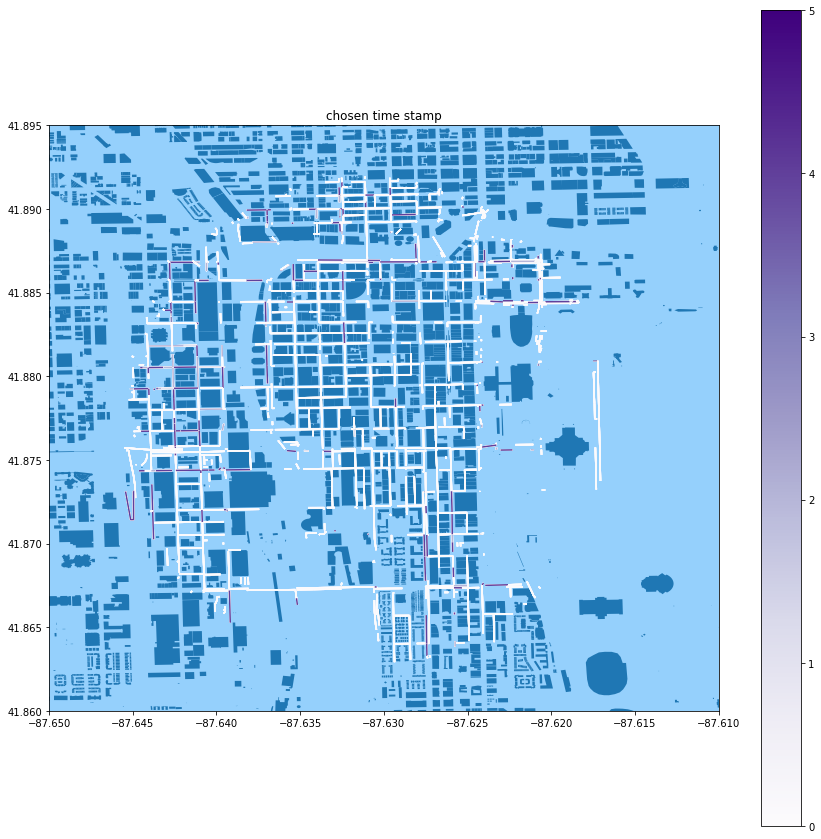

In [395]:
fig,ax = plt.subplots(figsize = (15,15))
merged_snap1.plot(ax=ax, column='cluster_num',cmap='Purples',vmin=0, vmax=5)
building_map.plot(ax=ax)
ax.set_facecolor('xkcd:light blue')
ax.set_title('chosen time stamp')
ax.set_ylim(41.86,41.895)
ax.set_xlim(-87.65,-87.61)
fig = ax.get_figure()
sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=0, vmax=5))
fig.colorbar(sm,ax=ax)

In [ ]:
sim_end=end(sim_snap_geojson)
build_agent_count_both=agent_to_building(sim_start,sim_end,building_map)
plot_start_end(sim_start,sim_end,build_agent_count_both)

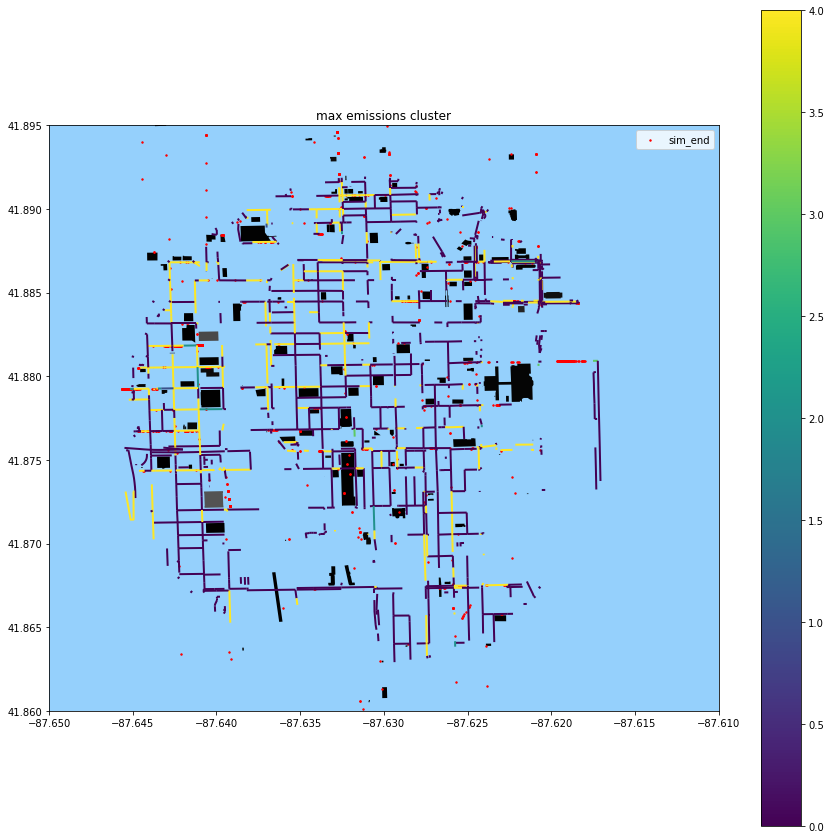

In [439]:
fig,ax = plt.subplots(figsize = (15,15))
merged_max.plot(ax=ax, column='cluster_num',cmap='viridis',vmin=0, vmax=4,linewidth=2)
build_agent_count_both.plot(ax=ax,column='VEHICLE_y',cmap='gray')
sim_end.plot(ax=ax, marker='o', color='red', markersize=2,label='sim_end')
ax.set_ylim(41.86,41.895)
ax.set_xlim(-87.65,-87.61)
ax.set_title('max emissions cluster')
ax.set_facecolor('xkcd:light blue')
fig = ax.get_figure()
sm = plt.cm.ScalarMappable(cmap='viridis', norm=plt.Normalize(vmin=0, vmax=4))
ax.legend()
fig.colorbar(sm,ax=ax)

In [423]:
for i in np.arange(1,1,1):
    merged=pd.merge(left=links,right=result[result['idx']==i], left_on='linkID', right_on='linkID')
    fig,ax = plt.subplots(figsize = (15,15))
    merged.plot(ax=ax, column='cluster_num',cmap='Purples',vmin=0, vmax=4)
    ax.set_facecolor('xkcd:light blue')
    ax.set_title(i)
    fig = ax.get_figure()
    sm = plt.cm.ScalarMappable(cmap='Purples', norm=plt.Normalize(vmin=0, vmax=4))
    fig.colorbar(sm,ax=ax)

In [424]:
def agent_to_building(sim_start,sim_end,building_map):
    building_map = building_map.to_crs(epsg=26916)
    building_map = building_map.assign(centroid=building_map.centroid)
    
    #START
    sim_start_gdf = gpd.GeoDataFrame(sim_start, geometry=gpd.points_from_xy(sim_start.X_COORD,sim_start.Y_COORD))
    sim_start_gdf.crs="EPSG:26916"
    
    min_dist = np.empty(len(sim_start_gdf))
    for i, agent in enumerate(sim_start_gdf.geometry):
        min_dist[i] = np.argmin([agent.distance(centroid) for centroid in building_map.centroid])
    sim_start_gdf['building_id'] = min_dist
    agent_count_start = sim_start_gdf.groupby('building_id').count()
    
    #END
    sim_end_gdf = gpd.GeoDataFrame(sim_end, geometry=gpd.points_from_xy(sim_end.X_COORD,sim_end.Y_COORD))
    sim_end_gdf.crs="EPSG:26916"
    min_dist = np.empty(len(sim_end_gdf))
    for i, agent in enumerate(sim_end_gdf.geometry):
        min_dist[i] = np.argmin([agent.distance(centroid) for centroid in building_map.centroid])
    sim_end_gdf['building_id'] = min_dist
    agent_count_end = sim_end_gdf.groupby('building_id').count()

    
    build_agent_count = building_map.merge(agent_count_start.VEHICLE,right_index=True,left_index=True) 
    build_agent_count_both=build_agent_count.merge(agent_count_end.VEHICLE,right_index=True,left_index=True)
    ##ADD 1 to move building ID??
    return build_agent_count_both

# Chicago Weather Data
Obtained from Weather underground.

In [442]:
weather=pd.read_csv('data/chicago_weather_underground.csv')

In [450]:
weather['datetime']=pd.to_datetime(weather['datetime'])

,datetime,temp_f,dewpt_f,humidity_pct,wind_dir,wind_spd_mph,gust_mph,airpressure_in,precip,condition
0,2017-01-09 05:53:00,23,12,63,SSW,14,0,29.62,0.0,Cloudy
1,2017-01-09 06:53:00,22,13,68,SSW,10,0,29.62,0.0,Fair
2,2017-01-09 07:53:00,22,13,68,SSW,10,0,29.61,0.0,Cloudy
3,2017-01-09 08:53:00,22,14,72,SSW,8,0,29.63,0.0,Cloudy
4,2017-01-09 09:53:00,23,14,68,S,10,0,29.63,0.0,Cloudy
...,...,...,...,...,...,...,...,...,...,...
182,2017-07-10 19:53:00,79,71,77,N,10,0,29.12,0.0,Mostly Cloudy
183,2017-07-10 20:53:00,77,70,79,NNE,3,0,29.14,0.0,Mostly Cloudy
184,2017-07-10 21:53:00,76,70,82,NNE,5,0,29.17,0.0,Cloudy
185,2017-07-10 22:53:00,76,70,82,N,5,0,29.16,0.0,Cloudy


In [480]:
for i in np.arange(0,len(weather),1):
    weather.iloc[i,10]=weather.iloc[i,0].month

In [482]:
weather_jan=weather[weather['month']==1]
weather_jan

,datetime,temp_f,dewpt_f,humidity_pct,wind_dir,wind_spd_mph,gust_mph,airpressure_in,precip,condition,month
0,2017-01-09 05:53:00,23,12,63,SSW,14,0,29.62,0.0,Cloudy,1
1,2017-01-09 06:53:00,22,13,68,SSW,10,0,29.62,0.0,Fair,1
2,2017-01-09 07:53:00,22,13,68,SSW,10,0,29.61,0.0,Cloudy,1
3,2017-01-09 08:53:00,22,14,72,SSW,8,0,29.63,0.0,Cloudy,1
4,2017-01-09 09:53:00,23,14,68,S,10,0,29.63,0.0,Cloudy,1
5,2017-01-09 10:53:00,26,15,63,SSW,14,0,29.62,0.0,Cloudy,1
6,2017-01-09 11:53:00,27,15,61,SW,9,0,29.62,0.0,Cloudy,1
7,2017-01-09 12:53:00,28,15,58,SSW,12,20,29.60,0.0,Cloudy,1


In [484]:
weather_july=weather[weather['month']==7]
weather_july

,datetime,temp_f,dewpt_f,humidity_pct,wind_dir,wind_spd_mph,gust_mph,airpressure_in,precip,condition,month
8,2017-07-04 00:53:00,69,58,68,NE,8,0,29.39,0.0,Partly Cloudy,7
9,2017-07-04 01:53:00,69,58,68,N,6,0,29.38,0.0,Partly Cloudy,7
10,2017-07-04 02:53:00,68,59,73,N,6,0,29.37,0.0,Mostly Cloudy,7
11,2017-07-04 03:53:00,68,61,78,NNE,5,0,29.38,0.0,Mostly Cloudy,7
12,2017-07-04 04:53:00,68,61,78,N,6,0,29.39,0.0,Mostly Cloudy,7
...,...,...,...,...,...,...,...,...,...,...,...
182,2017-07-10 19:53:00,79,71,77,N,10,0,29.12,0.0,Mostly Cloudy,7
183,2017-07-10 20:53:00,77,70,79,NNE,3,0,29.14,0.0,Mostly Cloudy,7
184,2017-07-10 21:53:00,76,70,82,NNE,5,0,29.17,0.0,Cloudy,7
185,2017-07-10 22:53:00,76,70,82,N,5,0,29.16,0.0,Cloudy,7


Text(0.5, 1.0, 'weather')

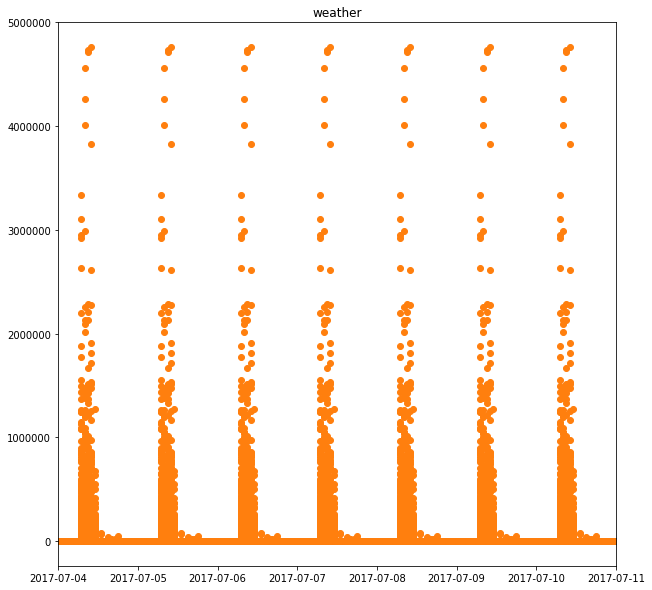

In [535]:
fig,ax = plt.subplots(figsize = (10,10))
ax.scatter(weather_july['datetime'],weather_july['temp_f'])
#ax.scatter(july_2017.loc[july_2017['linkID'],['date']],july_2017.loc[july_2017['linkID'],['quant_norm']])
ax.scatter(july_2017['date'],july_2017['emquant'])
ax.set_xlim(pd.to_datetime('2017-07-04'),pd.to_datetime('2017-07-11'))
ax.set_xlim(pd.to_datetime('2017-07-04'),pd.to_datetime('2017-07-11'))
ax.set_title('weather')

Text(0.5, 1.0, 'weather')

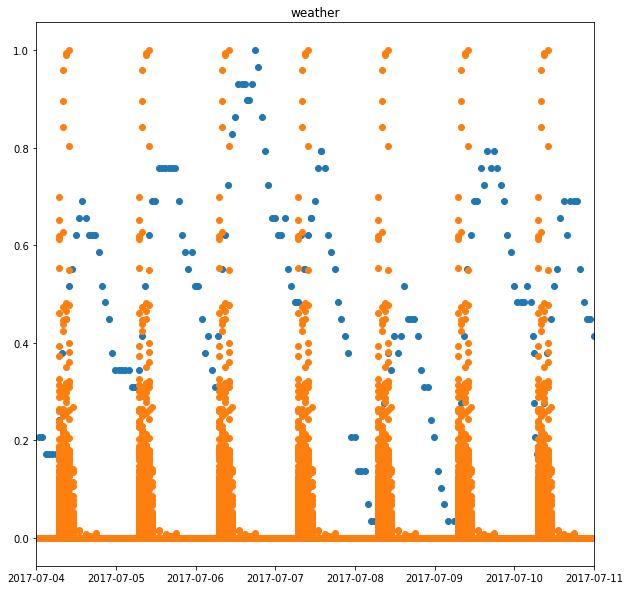

In [524]:
fig,ax = plt.subplots(figsize = (10,10))
ax.scatter(weather_july['datetime'],weather_july['temp_norm'])
#ax.scatter(july_2017.loc[july_2017['linkID'],['date']],july_2017.loc[july_2017['linkID'],['quant_norm']])
ax.scatter(july_2017['date'],july_2017['quant_norm'])
ax.set_xlim(pd.to_datetime('2017-07-04'),pd.to_datetime('2017-07-11'))
ax.set_xlim(pd.to_datetime('2017-07-04'),pd.to_datetime('2017-07-11'))
ax.set_title('weather')

normalize weather and emissions:   (x - xmin)/(xmax-xmin)

In [507]:
X = july_2017['emquant']
july_2017['quant_norm']= (X-X.min())/(X.max()-X.min())
july_2017

In [510]:
Y = weather_july['temp_f']
weather_july['temp_norm']= (Y-Y.min())/(Y.max()-Y.min())

/Users/elizabethperry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [530]:
Y = weather_jan['temp_f']
weather_jan['temp_norm']= (Y-Y.min())/(Y.max()-Y.min())
X = jan_2017['emquant']
jan_2017['quant_norm']= (X-X.min())/(X.max()-X.min())

/Users/elizabethperry/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


Text(0.5, 1.0, 'weather')

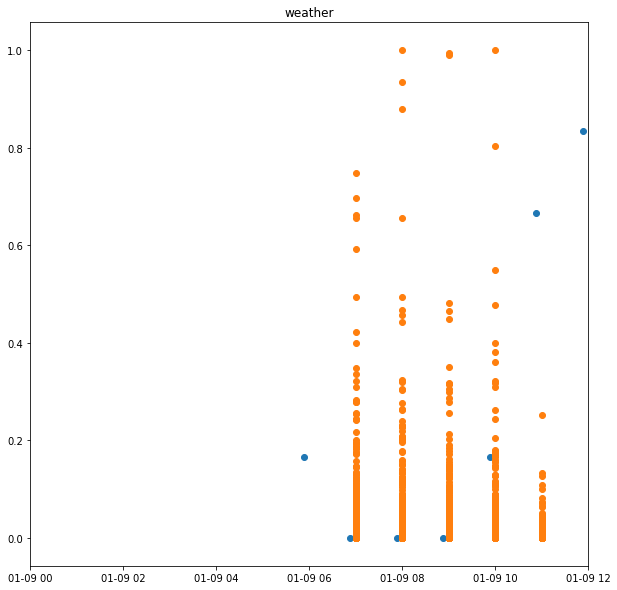

In [534]:
fig,ax = plt.subplots(figsize = (10,10))
ax.scatter(weather_jan['datetime'],weather_jan['temp_norm'])
#ax.scatter(july_2017.loc[july_2017['linkID'],['date']],july_2017.loc[july_2017['linkID'],['quant_norm']])
ax.scatter(jan_2017['date'],jan_2017['quant_norm'])
ax.set_xlim(pd.to_datetime('2017-01-09'),pd.to_datetime('2017-01-09 12:00'))
ax.set_xlim(pd.to_datetime('2017-01-09'),pd.to_datetime('2017-01-09 12:00'))
ax.set_title('weather')

Text(0.5, 1.0, 'weather')

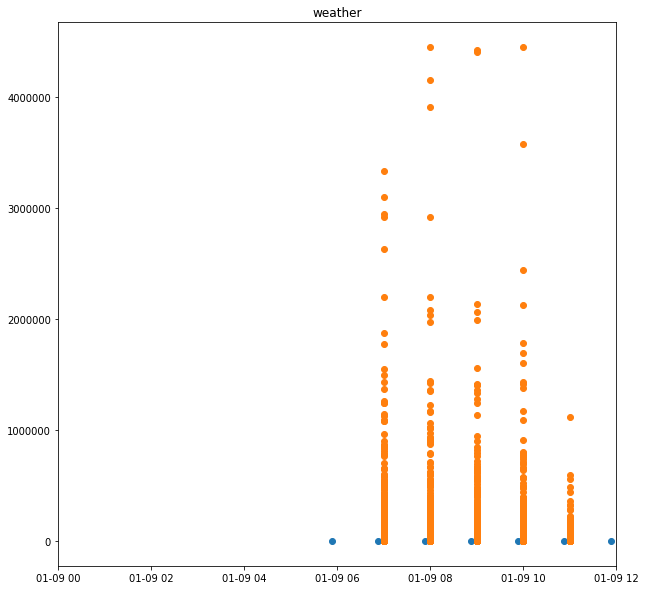

In [537]:
fig,ax = plt.subplots(figsize = (10,10))
ax.scatter(weather_jan['datetime'],weather_jan['temp_f'])
#ax.scatter(july_2017.loc[july_2017['linkID'],['date']],july_2017.loc[july_2017['linkID'],['quant_norm']])
ax.scatter(jan_2017['date'],jan_2017['emquant'])
ax.set_xlim(pd.to_datetime('2017-01-09'),pd.to_datetime('2017-01-09 12:00'))
ax.set_xlim(pd.to_datetime('2017-01-09'),pd.to_datetime('2017-01-09 12:00'))
ax.set_title('weather')